In [1]:
%matplotlib inline
import os
import sys
sys.path.append(f"{os.getcwd()}/../")
sys.path.append(os.path.abspath('/scratch/users/pdanie20/silicon/PD-stopping-power-ml'))
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
from matplotlib import pyplot as plt
from stopping_power_ml.io import get_charge_density_interpolator, load_directory
from stopping_power_ml.keras import build_fn as build_dense
from stopping_power_ml.integrator import TrajectoryIntegrator

import h5py 
from glob import glob
from tqdm.notebook import tqdm as tqdm

from keras.layers import Dense, Activation, Input
from keras.layers import Concatenate, Multiply, Add
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pickle as pkl
import numpy as np
import pandas as pd
import keras
import time
#plt.style.use(['science', 'no-latex'])


import functools
print = functools.partial(print, flush=True)

2024-10-11 13:17:41.610765: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-11 13:17:42.521998: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-11 13:17:43.584579: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-11 13:17:55.691039: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
model = keras.models.load_model('model_val_2.h5')
with open(os.path.join('/scratch/users/pdanie20/silicon/PD-stopping-power-ml/multiple-velocities', 'featurizer.pkl'), 'rb') as fp:
    featurizers = pkl.load(fp)


start_frame = pkl.load(open(os.path.join('/scratch/users/pdanie20/silicon/PD-stopping-power-ml/', 'Si_starting_frame.pkl'), 'rb'))
channel_data = pd.read_pickle(os.path.join('/scratch/users/pdanie20/silicon/PD-stopping-power-ml/multiple-velocities', 'channel_traj.pkl'))
random_data = pd.read_pickle(os.path.join('/scratch/users/pdanie20/silicon/PD-stopping-power-ml/multiple-velocities', 'random_traj.pkl'))

super_cell_lattice = start_frame.cell[0, 0] 
unit_cell_lattice = super_cell_lattice/3
print(super_cell_lattice, unit_cell_lattice)

M=1.6726219*10**-27/(9.10938356*10**-31)


30.469 10.156333333333334


## stopping force for 001 direction at v = 1

In [3]:
channel_data.head()
sel = channel_data['directory'].str.contains('silicon_data/2_Electronic_Stopping/H_Si/LDA_H_001_direction/v_1.0')
dat = channel_data[sel]
print(dat.keys())

Index(['frame_id', 'force', 'position', 'velocity', 'energy', 'file_id',
       'file', 'timestep', 'displacement', 'directory',
       'charge density at t=-4.00', 'charge density at t=-3.00',
       'charge density at t=-2.00', 'charge density at t=-1.00',
       'charge density at t=-0.50', 'charge density at t=0.00',
       'charge density at t=0.50', 'charge density at t=1.00',
       'charge density at t=2.00', 'AGNI projected eta=8.00e-01',
       'AGNI projected eta=1.23e+00', 'AGNI projected eta=1.88e+00',
       'AGNI projected eta=2.89e+00', 'AGNI projected eta=4.43e+00',
       'AGNI projected eta=6.80e+00', 'AGNI projected eta=1.04e+01',
       'AGNI projected eta=1.60e+01', 'ion-ion repulsion', 'velocity_mag'],
      dtype='object')


In [4]:
start_pos = np.array(dat['position'].iloc[0])/(np.diag(start_frame.cell)/3)
vel = np.array([0.00000, 0.00000, 1.00000])
print(start_pos)

[0.25004331 0.50006338 0.00083069]


In [5]:
traj_int = TrajectoryIntegrator(start_frame, model, featurizers)
force_calc = traj_int.create_force_calculator_given_displacement(start_pos, vel)

In [6]:
x = np.linspace(dat['displacement'].min(), dat['displacement'].max(), 200) - dat['displacement'].min()
v = dat['velocity_mag'].iloc[0]
print(v)
states = []
for i in tqdm(range(x.shape[0])):
    f = force_calc(x[i], v)
    states.append([x[i], f])

0.9986623711117663


  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
# plt.plot(dat['displacement'], dat['force'], ls = ':')
# states = np.vstack(states)
# plt.plot(states[:, 0] + dat['displacement'].min(), states[:, 1])

## for random trajectory

In [8]:
dat = random_data
print(dat.keys())

Index(['frame_id', 'force', 'position', 'velocity', 'energy', 'file_id',
       'file', 'timestep', 'displacement', 'directory',
       'charge density at t=-4.00', 'charge density at t=-3.00',
       'charge density at t=-2.00', 'charge density at t=-1.00',
       'charge density at t=-0.50', 'charge density at t=0.00',
       'charge density at t=0.50', 'charge density at t=1.00',
       'charge density at t=2.00', 'AGNI projected eta=8.00e-01',
       'AGNI projected eta=1.23e+00', 'AGNI projected eta=1.88e+00',
       'AGNI projected eta=2.89e+00', 'AGNI projected eta=4.43e+00',
       'AGNI projected eta=6.80e+00', 'AGNI projected eta=1.04e+01',
       'AGNI projected eta=1.60e+01', 'ion-ion repulsion', 'velocity_mag'],
      dtype='object')


In [9]:
def plot_performance(model, data):
    """Evaluate and plot the performance of the model on multiple velocities
    
    Args:
        model (keras.Model): Model to be trained
        data (pd.Dataframe): Training set
    """
    X_cols = featurizers.feature_labels()
    data['force_fit'] = model.predict(data[X_cols])

    # Plot results
    fig, axs = plt.subplots(1, 2)

    velocity = []
    stopping_pred = []
    stopping_actual = []
    for gid, group in data.groupby('directory'):
        # Store the velocity
        velocity.append(group['velocity_mag'].mean())
        print(group['velocity_mag'].mean(), group.shape)
        
        # Plot the performance on a segment of the dataset
        label = 'v={:.1f}'.format(group['velocity_mag'].mean())
        
        for a in axs[:1]:
            # print(group['displacement'].head())
            my_line, = a.plot(group['displacement'], group['force'], linestyle='--',
                                  label=label)

            a.plot(group['displacement'], group['force_fit'].tolist(), color=my_line.get_color(), lw=3, alpha=0.5)
            
            a.set_xlabel('Displacement ($a_0$)')
            a.set_ylabel('Force ($E_H / a_0$)')
            
        
        # Store the stopping pwoers
        stopping_pred.append(group['force_fit'].mean())
        stopping_actual.append(group['force'].mean())
        
    # Plot the stopping power
    axs[1].scatter(velocity, stopping_actual, marker='o', s=80, facecolor='none', edgecolor='k', label='TD-DFT')
    axs[1].scatter(velocity, stopping_pred, marker='o', facecolor='crimson', edgecolor='k', label='ML')
    
    axs[1].set_ylabel('Stopping Power ($E_H / a_0$)')
    axs[1].set_xlabel('Velocity (at. u.)')
    # axs[2].set_ylim(0, max(axs[2].get_ylim()))
    # axs[2].set_xlim(0, 4.2)
    axs[1].legend()
    
    fig.set_size_inches(8, 2.5)
    fig.tight_layout()
    
    # Print the MAPE
    stopping_mape = np.abs(np.subtract(stopping_actual, stopping_pred) / stopping_actual).mean()
    print(f'Mean percent error: {stopping_mape * 100:.2f}%')
    
    return np.vstack([velocity, stopping_pred]).T, np.vstack([velocity, stopping_actual]).T

def compute_random_stopping_power(speed: float) -> float:
    """Compute the stopping power for the random trajectory
    
    Args:
        speed: Magnitude of the velocity
    Returns:
        Stopping power
    """
    
    # Get the positions along the trajectory
    random_positions = random_data[random_data['file'].str.contains('v_7.5')].copy()
    
    # Update the velocity
    random_positions['velocity'] = random_positions['velocity']/7.5*speed
    
    # Run the model
    featurizers.set_chunksize(None)
    x = featurizers.featurize_many(random_positions[['position', 'velocity']], pbar=False)
    forces = model.predict(np.array(x))
    
    plt.plot(random_positions['displacement'], forces)
    return forces.mean()

3514/3514 ━━━━━━━━━━━━━━━━━━━━ 4s 879us/step
1.5000000020367035 (15723, 30)
9.999999999287636 (15958, 30)
13.00000000336104 (7968, 30)
1.9999999965608248 (15792, 30)
3.0000000020925777 (15861, 30)
4.0000000013634045 (15896, 30)
5.000000000634232 (15917, 30)
7.499999999960936 (5944, 30)
0.49742859541085815 (3369, 30)
Mean percent error: 2.05%


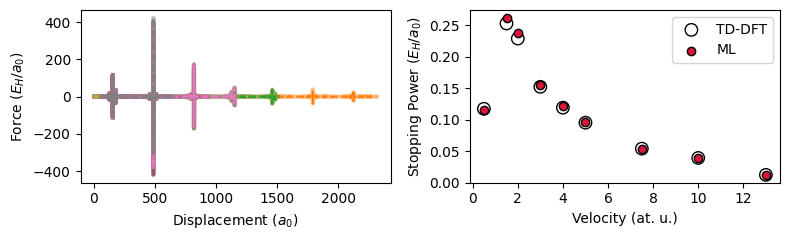

 994/3514 ━━━━━━━━━━━━━━━━━━━━ 2s 814us/step

1057/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 813us/step

1120/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 812us/step

1183/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step

1246/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step

1309/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 810us/step

1372/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 810us/step

1435/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 809us/step

1498/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 809us/step

1561/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 809us/step

1624/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 808us/step

1687/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 808us/step

1749/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 808us/step

1812/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 808us/step

1887/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 802us/step

1963/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step

2040/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step

2117/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step

2194/3514 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step

2271/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step

2348/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step

2425/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step

2502/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step

2579/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step

2656/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step

2733/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step

2810/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step

2887/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step

2964/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step

3041/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step

3118/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step

3195/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step

3272/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step

3349/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step

3425/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step

3501/3514 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step

3514/3514 ━━━━━━━━━━━━━━━━━━━━ 3s 735us/step


1.5000000020367035 (15723, 30)


9.999999999287636 (15958, 30)


13.00000000336104 (7968, 30)


1.9999999965608248 (15792, 30)


3.0000000020925777 (15861, 30)


4.0000000013634045 (15896, 30)


5.000000000634232 (15917, 30)


7.499999999960936 (5944, 30)


0.49742859541085815 (3369, 30)


Mean percent error: 5.86%


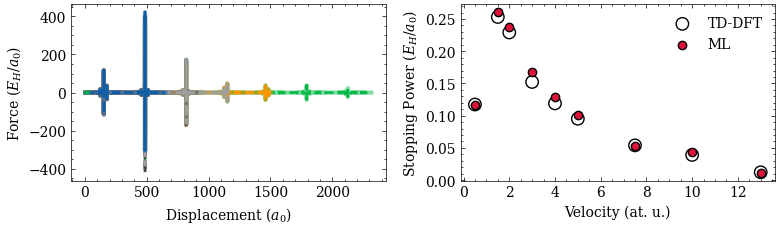

In [10]:
sp_random_tmp, sp_random = plot_performance(model, dat)

  0%|          | 0/100 [00:00<?, ?it/s]

Process ForkPoolWorker-111:
Process ForkPoolWorker-107:
Process ForkPoolWorker-96:
Process ForkPoolWorker-125:
Process ForkPoolWorker-98:
Process ForkPoolWorker-99:
Process ForkPoolWorker-124:
Process ForkPoolWorker-123:
Process ForkPoolWorker-104:
Process ForkPoolWorker-116:
Process ForkPoolWorker-122:
Process ForkPoolWorker-114:
Process ForkPoolWorker-119:
Process ForkPoolWorker-117:
Process ForkPoolWorker-108:
Process ForkPoolWorker-101:
Process ForkPoolWorker-105:
Process ForkPoolWorker-102:
Process ForkPoolWorker-112:
Process ForkPoolWorker-118:
Process ForkPoolWorker-94:
Process ForkPoolWorker-127:
Process ForkPoolWorker-128:
Process ForkPoolWorker-131:
Process ForkPoolWorker-109:
Process ForkPoolWorker-106:
Process ForkPoolWorker-115:
Process ForkPoolWorker-130:
Process ForkPoolWorker-121:
Process ForkPoolWorker-129:
Process ForkPoolWorker-95:
Process ForkPoolWorker-126:
Process ForkPoolWorker-103:
Process ForkPoolWorker-113:
Process ForkPoolWorker-97:
Process ForkPoolWorker-110

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step

 68/186 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step

140/186 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step

 70/186 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step

155/186 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step

 79/186 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step

165/186 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 74/186 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step

150/186 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 74/186 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step

149/186 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 74/186 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step

149/186 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 75/186 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step

151/186 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 75/186 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step

151/186 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step

 26/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

 55/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 83/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

107/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

131/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

155/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

180/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 75/186 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step

151/186 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 75/186 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step

151/186 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

 89/186 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step

166/186 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 75/186 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step

152/186 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 75/186 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step

151/186 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 73/186 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step

149/186 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 74/186 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step

149/186 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 73/186 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step

148/186 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 74/186 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step

149/186 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 74/186 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step

150/186 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 75/186 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step

150/186 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

 89/186 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step

176/186 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

 90/186 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step

182/186 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 74/186 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step

149/186 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 78/186 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step

169/186 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

 75/186 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step

151/186 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 74/186 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step

149/186 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 73/186 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step

148/186 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 74/186 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step

153/186 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 74/186 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step

150/186 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step

 75/186 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step

151/186 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step

 27/186 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

 50/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 76/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

104/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

133/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

159/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

183/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 82/186 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step

173/186 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 73/186 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step

147/186 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 74/186 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step

150/186 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

 88/186 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step

166/186 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 75/186 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step

151/186 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

 89/186 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step

180/186 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 74/186 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step

150/186 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 74/186 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step

150/186 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 74/186 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step

152/186 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step

 31/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

 59/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 88/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

118/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

145/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

172/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

 89/186 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step

180/186 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step

 74/186 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step

165/186 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 74/186 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step

149/186 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step

 34/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

 63/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 88/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

113/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

138/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

161/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step

 27/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

 50/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 73/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

101/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

125/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

150/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

178/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step

 26/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

 49/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 73/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 97/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

121/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

150/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

179/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

 88/186 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step

179/186 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

 89/186 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step

179/186 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step

 21/186 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

 48/186 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

 76/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

104/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

133/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

163/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step

 89/186 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step

180/186 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step

 34/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

 58/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 84/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

107/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

131/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

154/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

178/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

 89/186 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step

179/186 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

 89/186 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step

180/186 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

 89/186 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step

180/186 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 74/186 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step

150/186 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step

 23/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

 46/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 73/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

100/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

124/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

149/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

179/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 75/186 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step

151/186 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

 88/186 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step

178/186 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

 89/186 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step

180/186 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

 89/186 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step

174/186 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step

 25/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

 52/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 81/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

110/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

139/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

163/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step

 29/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

 55/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 83/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

111/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

140/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

164/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step

 87/186 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step

142/186 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step

167/186 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  1/186 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step

 26/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

 54/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 83/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

111/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

136/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

162/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 78/186 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step

169/186 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

 88/186 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step

180/186 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step

 23/186 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

 48/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 72/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 95/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

119/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

143/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

172/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step

 26/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

 54/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 83/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

112/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

139/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

163/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 74/186 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step

150/186 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step

 21/186 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

 44/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 68/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 92/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

112/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

136/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

164/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step

 27/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

 52/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 81/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

110/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

139/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

168/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 74/186 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step

149/186 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step

 27/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

 56/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 84/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

113/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

142/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

170/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

 89/186 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step

179/186 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

 90/186 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step

174/186 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step

 30/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

 58/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 86/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

121/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

150/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

179/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

 90/186 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step

182/186 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step

 26/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

 55/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 86/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

115/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

144/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

173/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

 89/186 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step

177/186 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 74/186 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step

149/186 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step

 29/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

 54/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 77/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

101/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

125/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

149/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

174/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step

 27/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

 50/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 74/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 99/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

122/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

146/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

170/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 74/186 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step

150/186 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

 89/186 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step

180/186 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 73/186 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step

160/186 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 74/186 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step

149/186 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step

 32/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

 61/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 90/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

119/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

148/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

178/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step

 26/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

 50/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 73/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 99/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

128/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

157/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

 89/186 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step

180/186 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step

 32/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

 60/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 89/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

118/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

145/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

171/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

 74/186 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step

149/186 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step

 26/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

 54/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 83/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

112/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

141/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

166/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step

 37/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

 61/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 85/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

111/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

136/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

160/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

 89/186 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step

177/186 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step


  1/186 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step

 32/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

 57/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 80/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

104/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

127/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

150/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

175/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


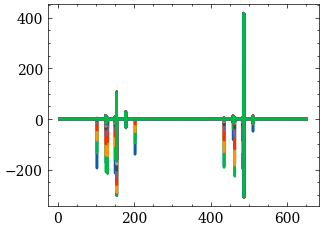

In [ ]:
sp_random_ML = []

for vmag in tqdm(np.linspace(channel_data['velocity_mag'].min(), channel_data['velocity_mag'].max(), 100, endpoint = True)):
    sp_random_ML.append([vmag, compute_random_stopping_power(vmag)])

sp_random_ML = np.vstack(sp_random_ML)

In [ ]:
plt.plot(sp_random[:, 0]**2/2*M/1000*27.2114, sp_random[:, 1]*51.421, 'x')
plt.plot(sp_random_tmp[:, 0]**2/2*M/1000*27.2114, sp_random_tmp[:, 1]*51.421, 'o')
plt.plot(sp_random_ML[:, 0]**2/2*M/1000*27.2114, sp_random_ML[:, 1]*51.421)
plt.xscale('log')

## for all 001 stopping power

In [ ]:
def plot_channeling_stopping_power(grp, period):
    start_pos = np.array(grp['position'].iloc[0])/(np.diag(start_frame.cell)/3) # start_pos defined in the conventional unit cell
    vel = np.array(grp['velocity'].iloc[0])
    traj_int = TrajectoryIntegrator(start_frame, model, featurizers)
    force_calc = traj_int.create_force_calculator_given_displacement(start_pos, vel)
    x = np.linspace(grp['displacement'].min(), grp['displacement'].max(), 110) - grp['displacement'].min()
    v = grp['velocity_mag'].iloc[0]
    states = []
    for i in tqdm(range(x.shape[0])):
        f = force_calc(x[i], v)
        states.append([x[i] + grp['displacement'].min(), f])
        
    states = np.vstack(states)
    line, = plt.plot(states[:, 0], states[:, 1])
    plt.plot(grp['displacement'], grp['force'], ls = ':', c = line.get_color())

    s = period
    plt.axvline(s, c = 'k', ls = '--')
    plt.axvline(s + period, c = 'k', ls = '--')

    sp_tddft = [v, grp[(grp['displacement'] >= s) & (grp['displacement'] < s + period)]['force'].mean()]
    sel = np.where((states[:, 0] >= s) & (states[:, 0] < s + period))
    sp_pred = [v, np.mean(states[sel][:, 1])]
    return sp_tddft, sp_pred

def compute_channeling_stopping_power(dat, dir, vmag, period):
    start_pos = np.array(dat['position'].iloc[0])/(np.diag(start_frame.cell)/3) # start_pos defined in the conventional unit cell
    
    traj_int = TrajectoryIntegrator(start_frame, model, featurizers)
    force_calc = traj_int.create_force_calculator_given_displacement(start_pos, dir)
    
    x = np.linspace(0, period, 105)

    fall = []
    for i in range(x.shape[0]):
        f = force_calc(x[i], vmag)
        fall.append(f)    
    return fall

In [ ]:
dir = '001'
sel = channel_data['directory'].str.contains(f'silicon_data/2_Electronic_Stopping/H_Si/LDA_H_{dir}_direction/')
dat = channel_data[sel]
period = np.sqrt(sum(int(char) for char in dir)) * unit_cell_lattice # range to take the average of the stopping power 
print(dat.keys())
print(period)

In [ ]:
sp001 = []
sp001_tmp = []

for gid, grp in tqdm(dat.groupby('directory')):
    tddft, ml = plot_channeling_stopping_power(grp, period)
    sp001.append(tddft)
    sp001_tmp.append(ml)
sp001 = np.vstack(sp001)
sp001_tmp = np.vstack(sp001_tmp)
plt.figure()
l, = plt.plot(sp001[:, 0], sp001[:, 1], 'x', label = "001")
plt.plot(sp001_tmp[:, 0], sp001_tmp[:, 1], 'o', markerfacecolor='None', c = l.get_color())

In [ ]:
sp001_ML = []

for vmag in tqdm(np.linspace(channel_data['velocity_mag'].min(), channel_data['velocity_mag'].max(), 100, endpoint = True)):
    fall = compute_channeling_stopping_power(dat, np.array([0, 0, 1]), vmag, period)
    
    sp001_ML.append([vmag, np.mean(fall)])

sp001_ML = np.vstack(sp001_ML)

## stopping force for 011 direction...

In [ ]:
dir = '011'
sel = channel_data['directory'].str.contains(f'silicon_data/2_Electronic_Stopping/H_Si/LDA_H_{dir}_direction/')
dat = channel_data[sel]
period = np.sqrt(sum(int(char) for char in dir)) * unit_cell_lattice # range to take the average of the stopping power 
print(dat.keys())
print(period)

In [ ]:
sp011 = []
sp011_tmp = []

for gid, grp in tqdm(dat.groupby('directory')):
    tddft, ml = plot_channeling_stopping_power(grp, period)
    sp011.append(tddft)
    sp011_tmp.append(ml)

sp011 = np.vstack(sp011)
sp011_tmp = np.vstack(sp011_tmp)


In [ ]:
sp011_ML = []

for vmag in tqdm(np.linspace(channel_data['velocity_mag'].min(), channel_data['velocity_mag'].max(), 100, endpoint = True)):
    fall = compute_channeling_stopping_power(dat, np.array([0, -1, 1]), vmag, period)
    sp011_ML.append([vmag, np.mean(fall)])

sp011_ML = np.vstack(sp011_ML)

## stopping force for 111 direction

In [ ]:
dir = '111'
sel = channel_data['directory'].str.contains(f'silicon_data/2_Electronic_Stopping/H_Si/LDA_H_{dir}_direction/')
dat = channel_data[sel]
period = np.sqrt(sum(int(char) for char in dir)) * unit_cell_lattice # range to take the average of the stopping power 
print(dat.keys())
print(period)

In [ ]:
sp111 = []
sp111_tmp = []

for gid, grp in tqdm(dat.groupby('directory')):
    tddft, ml = plot_channeling_stopping_power(grp, period)
    sp111.append(tddft)
    sp111_tmp.append(ml)
    
sp111 = np.vstack(sp111)
sp111_tmp = np.vstack(sp111_tmp)

In [ ]:
sp111_ML = []
for vmag in tqdm(np.linspace(channel_data['velocity_mag'].min(), channel_data['velocity_mag'].max(), 100, endpoint = True)):
    fall = compute_channeling_stopping_power(dat, np.array([1, 1, 1]), vmag, period)
    sp111_ML.append([vmag, np.mean(fall)])
sp111_ML = np.vstack(sp111_ML)

In [ ]:
with h5py.File(f'sp.dat.h5', 'w') as h5file:
    # Create a dataset with compression
    dataset = h5file.create_dataset('001/tddft', data = sp001, compression='gzip', compression_opts=4)
    dataset = h5file.create_dataset('001/ml', data = sp001_ML, compression='gzip', compression_opts=4)
    dataset = h5file.create_dataset('011/tddft', data = sp011, compression='gzip', compression_opts=4)
    dataset = h5file.create_dataset('011/ml', data = sp011_ML, compression='gzip', compression_opts=4)
    dataset = h5file.create_dataset('111/tddft', data = sp111, compression='gzip', compression_opts=4)
    dataset = h5file.create_dataset('111/ml', data = sp111_ML, compression='gzip', compression_opts=4)
    dataset = h5file.create_dataset('random/tddft', data = sp_random, compression='gzip', compression_opts=4)
    dataset = h5file.create_dataset('random/ml', data = sp_random_ML, compression='gzip', compression_opts=4)
    
    
def plot_sp(tddft, ml, label):
    l, = plt.plot(ml[:, 0]**2/2*M/1000*27.2114, ml[:, 1]*51.421, label = label)
    plt.plot(tddft[:, 0]**2/2*M/1000*27.2114, tddft[:, 1]*51.421, 'x', markerfacecolor='None', c= l.get_color())

plot_sp(sp001, sp001_ML, label = "001")
plot_sp(sp011, sp011_ML, label = "011")
plot_sp(sp111, sp111_ML, label = "111")
plot_sp(sp_random, sp_random_ML, label = "off")

plt.legend()
plt.xscale('log')
plt.xlabel("Kinetic Energy (keV)")
plt.ylabel("Stopping power (eV/$\mathrm{\AA}$)")

plt.savefig("Sispcom.png", dpi = 300)

In [ ]:
l, = plt.plot(sp001[:, 0], sp001[:, 1], 'x', label = "001")
plt.plot(sp001_tmp[:, 0], sp001_tmp[:, 1], 'o', markerfacecolor='None', c = l.get_color())

l, = plt.plot(sp011[:, 0], sp011[:, 1], 'x', label = "011")
plt.plot(sp011_tmp[:, 0], sp011_tmp[:, 1], 'o', markerfacecolor='None', c = l.get_color())

l, = plt.plot(sp111[:, 0], sp111[:, 1], 'x', label = "111")
plt.plot(sp111_tmp[:, 0], sp111_tmp[:, 1], 'o', markerfacecolor='None', c = l.get_color())

plt.legend()
plt.xlabel("velocity (at. u.)")
plt.ylabel("stopping power (at. u.)")